✅ Using All 8 VIF Features: ['age', 'sex', 'test_time', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']

📌 Model 1: VIF-BOBE-RRF
Test MSE: 0.0023233
10-Fold CV MSE: 0.0017555

📌 Model 2: VIF-RSOBE-RRF
Test MSE: 0.0022433
10-Fold CV MSE: 0.0018000


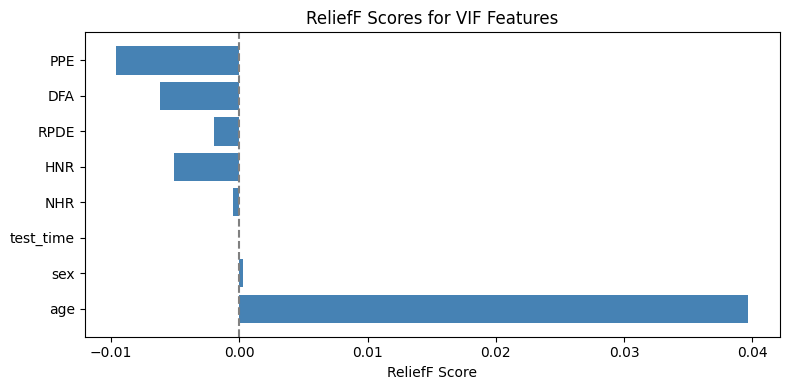

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# ------------------------
# 1. Load the VIF-reduced data
# ------------------------
data = pd.read_excel("VIFdata.xlsx")  # 8 features + 1 target column

# Split into features (X) and target (y)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# ------------------------
# 2. ReliefF scores for all 8 features (for visualization only)
# ------------------------
feature_names = ['age', 'sex', 'test_time', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']
rrf_scores = [0.0397, 0.0003, 0, -0.0005, -0.0051, -0.0020, -0.0062, -0.0096]

rrf_df = pd.DataFrame({'feature': feature_names, 'score': rrf_scores})

# Use all features (do not filter)
selected_features = rrf_df['feature'].tolist()
print("✅ Using All 8 VIF Features:", selected_features)

X_selected = X[selected_features]

# ------------------------
# 3. Train/Test Split (80/20)
# ------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

# 10-Fold CV setup
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# ------------------------
# 4. Model 1: VIF-BOBE-RRF Pipeline (Scaler + Bagging)
# ------------------------
model1 = Pipeline([
    ('scaler', StandardScaler()),
    ('bagging', BaggingRegressor(
        estimator=DecisionTreeRegressor(min_samples_leaf=2),
        n_estimators=477,
        max_features=len(selected_features),  # 8 features
        random_state=42,
        n_jobs=-1
    ))
])

model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
mse1 = mean_squared_error(y_test, y_pred1)

cv_mse1 = -cross_val_score(model1, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()

print("\n📌 Model 1: VIF-BOBE-RRF")
print(f"Test MSE: {mse1:.7f}")
print(f"10-Fold CV MSE: {cv_mse1:.7f}")

# ------------------------
# 5. Model 2: VIF-RSOBE-RRF Pipeline (Scaler + Bagging)
# ------------------------
model2 = Pipeline([
    ('scaler', StandardScaler()),
    ('bagging', BaggingRegressor(
        estimator=DecisionTreeRegressor(min_samples_leaf=2),
        n_estimators=121,
        max_features=len(selected_features),  # 8 features
        random_state=42,
        n_jobs=-1
    ))
])

model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
mse2 = mean_squared_error(y_test, y_pred2)

cv_mse2 = -cross_val_score(model2, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean()

print("\n📌 Model 2: VIF-RSOBE-RRF")
print(f"Test MSE: {mse2:.7f}")
print(f"10-Fold CV MSE: {cv_mse2:.7f}")

# ------------------------
# 6. Plot ReliefF Feature Importances
# ------------------------
plt.figure(figsize=(8, 4))
plt.barh(rrf_df['feature'], rrf_df['score'], color='steelblue')
plt.axvline(0, color='gray', linestyle='--')
plt.title("ReliefF Scores for VIF Features")
plt.xlabel("ReliefF Score")
plt.tight_layout()
plt.show()


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample
import numpy as np

def evaluate_model_advanced(model, X_train, y_train, X_test, y_test, model_name, n_bootstrap=1000):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics for training set
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Metrics for testing set
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Cohen's f squared (effect size) on test set
    f_squared = test_r2 / (1 - test_r2) if test_r2 < 1 else np.inf

    # CV_MAE on test set
    y_test_mean = np.mean(y_test)
    cv_mae = test_mae / y_test_mean if y_test_mean != 0 else np.nan

    # Bootstrap confidence intervals for MAE and RMSE on test set
    mae_samples = []
    rmse_samples = []
    for _ in range(n_bootstrap):
        indices = resample(range(len(y_test)), replace=True)
        y_true_bs = y_test.iloc[indices] if hasattr(y_test, "iloc") else y_test[indices]
        y_pred_bs = y_test_pred[indices]
        mae_bs = mean_absolute_error(y_true_bs, y_pred_bs)
        rmse_bs = np.sqrt(mean_squared_error(y_true_bs, y_pred_bs))
        mae_samples.append(mae_bs)
        rmse_samples.append(rmse_bs)

    ci_lower_mae = np.percentile(mae_samples, 2.5)
    ci_upper_mae = np.percentile(mae_samples, 97.5)
    ci_lower_rmse = np.percentile(rmse_samples, 2.5)
    ci_upper_rmse = np.percentile(rmse_samples, 97.5)

    # Averages
    avg_rmse = (train_rmse + test_rmse) / 2
    avg_mae = (train_mae + test_mae) / 2
    avg_r2 = (train_r2 + test_r2) / 2

    # Output
    print(f"\n📊 {model_name} Performance:")
    print(f"Training RMSE: {train_rmse:.6f}")
    print(f"Training MAE:  {train_mae:.6f}")
    print(f"Training R²:   {train_r2:.6f}")
    print(f"Testing RMSE:  {test_rmse:.6f}")
    print(f"Testing MAE:   {test_mae:.6f}")
    print(f"Testing R²:    {test_r2:.6f}")
    print(f"Average RMSE:  {avg_rmse:.6f}")
    print(f"Average MAE:   {avg_mae:.6f}")
    print(f"Average R²:    {avg_r2:.6f}")
    print(f"Cohen's f² (effect size): {f_squared:.6f}")
    print(f"CV_MAE: {cv_mae:.6f}")
    print(f"95% CI MAE: [{ci_lower_mae:.6f}, {ci_upper_mae:.6f}]")
    print(f"95% CI RMSE: [{ci_lower_rmse:.6f}, {ci_upper_rmse:.6f}]")

# Usage example:
evaluate_model_advanced(model1, X_train, y_train, X_test, y_test, "Model 1: VIF-BOBE-RRF")
evaluate_model_advanced(model2, X_train, y_train, X_test, y_test, "Model 2: VIF-RSOBE-RRF")



📊 Model 1: VIF-BOBE-RRF Performance:
Training RMSE: 0.018542
Training MAE:  0.007247
Training R²:   0.993283
Testing RMSE:  0.048201
Testing MAE:   0.017340
Testing R²:    0.952733
Average RMSE:  0.033371
Average MAE:   0.012294
Average R²:    0.973008
Cohen's f² (effect size): 20.156499
CV_MAE: 0.037151
95% CI MAE: [0.014609, 0.020108]
95% CI RMSE: [0.038519, 0.059076]

📊 Model 2: VIF-RSOBE-RRF Performance:
Training RMSE: 0.018761
Training MAE:  0.007326
Training R²:   0.993124
Testing RMSE:  0.047364
Testing MAE:   0.016989
Testing R²:    0.954360
Average RMSE:  0.033063
Average MAE:   0.012157
Average R²:    0.973742
Cohen's f² (effect size): 20.910640
CV_MAE: 0.036398
95% CI MAE: [0.014201, 0.019899]
95% CI RMSE: [0.038233, 0.057364]


In [11]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

# Custom MAE scorer (greater_is_better=False for error metrics)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Compute negative MAEs (so take absolute to interpret)
mae_scores_model1 = -cross_val_score(model1, X_train, y_train, scoring=mae_scorer, cv=cv)
mae_scores_model2 = -cross_val_score(model2, X_train, y_train, scoring=mae_scorer, cv=cv)

print("Model 1 - MAE scores from 10-fold CV:", mae_scores_model1)
print("Model 2 - MAE scores from 10-fold CV:", mae_scores_model2)


Model 1 - MAE scores from 10-fold CV: [0.02074001 0.01639347 0.01729039 0.0171935  0.01706685 0.01792544
 0.01462169 0.01704147 0.01855942 0.01732273]
Model 2 - MAE scores from 10-fold CV: [0.02102888 0.01659898 0.01712682 0.01787324 0.01753075 0.01780631
 0.0148141  0.0175292  0.01870066 0.01771028]


In [12]:
from scipy.stats import ttest_rel, wilcoxon

# Paired t-test
t_stat, p_ttest = ttest_rel(mae_scores_model1, mae_scores_model2)

# Wilcoxon signed-rank test
w_stat, p_wilcoxon = wilcoxon(mae_scores_model1, mae_scores_model2)

print(f"Paired t-test p-value: {p_ttest:.6f}")
print(f"Wilcoxon signed-rank test p-value: {p_wilcoxon:.6f}")


Paired t-test p-value: 0.013539
Wilcoxon signed-rank test p-value: 0.013672


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 3955, number of used features: 8
[LightGBM] [Info] Start training from score 0.461653
            Model        R2      RMSE       MAE  Cohen's f^2    CV_MAE  \
10   RandomForest  0.955510  0.046764  0.016475    21.476768  2.656538   
11        XGBoost  0.949419  0.049862  0.027151    18.770423  1.540319   
12       LightGBM  0.943410  0.052740  0.029708    16.671114  1.466878   
9          RSODTR  0.892035  0.072848  0.042836     8.262261  1.375543   
8           DTree  0.892035  0.072848  0.042836     8.262261  1.375543   
13       CatBoost  0.872222  0.079251  0.059369     6.826085  0.884250   
6         LSBoost  0.634221  0.134086  0.110819     1.733895  0.681177   
7   Bayes_LSBoost  0.634221  0.134086  0.110819     1.733895  0.6811

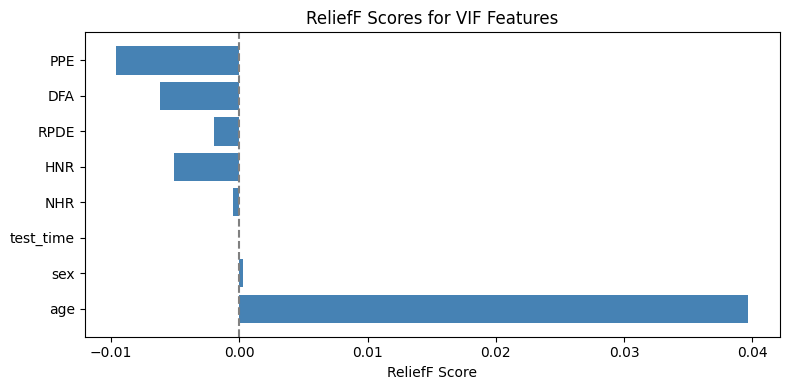

In [13]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ttest_rel, t
import matplotlib.pyplot as plt

# External libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# ------------------------
# 1. Load the VIF-reduced data
# ------------------------
data = pd.read_excel("VIFdata.xlsx")  # 8 features + 1 target column

# ------------------------
# 2. ReliefF scores for specific models only
# ------------------------
feature_names = ['age', 'sex', 'test_time', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']
rrf_scores = [0.0397, 0.0003, 0, -0.0005, -0.0051, -0.0020, -0.0062, -0.0096]

rrf_df = pd.DataFrame({'feature': feature_names, 'score': rrf_scores})
selected_features_rrf = rrf_df['feature'].tolist()

# Use VIF features for most models
X_vif = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Use RReliefF features only for specific models
X_rrf = data[selected_features_rrf]

# ------------------------
# 3. Train/Test Split (80/20)
# ------------------------
X_vif_train, X_vif_test, y_train, y_test = train_test_split(
    X_vif, y, test_size=0.2, random_state=42
)

X_rrf_train, X_rrf_test, _, _ = train_test_split(
    X_rrf, y, test_size=0.2, random_state=42
)

# 10-Fold CV setup
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# ------------------------
# 4. Define Models (Removed GPR_PCA and added requested models)
# ------------------------
models = {
    'MLR': Pipeline([
        ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
        ('regressor', LinearRegression())
    ]),
    'GPR': Pipeline([
        ('scaler', StandardScaler()),
        ('gpr', GaussianProcessRegressor(kernel=RBF()))
    ]),
    'SVR_PCA': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('svr', SVR(kernel='rbf'))
    ]),
    'MLP_PCA': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('mlp', MLPRegressor(hidden_layer_sizes=(100,), activation='relu', max_iter=1000))
    ]),
    'BOMLP': Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000))
    ]),
    'RSOMLP': Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000))
    ]),
    'LSBoost': GradientBoostingRegressor(n_estimators=30, learning_rate=0.1, min_samples_leaf=8),
    'Bayes_LSBoost': GradientBoostingRegressor(n_estimators=30, learning_rate=0.1, min_samples_leaf=8),
    'DTree': DecisionTreeRegressor(min_samples_leaf=36),
    'RSODTR': DecisionTreeRegressor(min_samples_leaf=36),
    
    # New models added:
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'CatBoost': CatBoostRegressor(iterations=100, learning_rate=0.1, random_state=42, verbose=0)
}

# ------------------------
# 5. Evaluate Models
# ------------------------
results = []

rrf_models = ['Bayes_LSBoost', 'RSODTR']  # Models using RReliefF features

def compute_stats(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    f_squared = r2 / (1 - r2) if r2 < 1 else np.inf
    cv_mae = np.std(np.abs(y_true - y_pred)) / np.mean(np.abs(y_true - y_pred))
    n = len(y_true)
    se = rmse / np.sqrt(n)
    ci = t.interval(0.95, df=n-1, loc=rmse, scale=se)
    residuals = y_true - y_pred
    _, p_value = ttest_rel(y_true, y_pred)
    return r2, rmse, mae, f_squared, cv_mae, ci[0], ci[1], p_value

for name, model in models.items():
    if name in rrf_models:
        model.fit(X_rrf_train, y_train)
        y_pred = model.predict(X_rrf_test)
    else:
        model.fit(X_vif_train, y_train)
        y_pred = model.predict(X_vif_test)
    stats_values = compute_stats(y_test, y_pred)
    results.append([name] + list(stats_values))

# ------------------------
# 6. Display Results
# ------------------------
columns = [
    'Model', 'R2', 'RMSE', 'MAE', "Cohen's f^2", 'CV_MAE', 'CI_Lower', 'CI_Upper', 'P_Value'
]
results_df = pd.DataFrame(results, columns=columns)
print(results_df.sort_values(by='R2', ascending=False))

# ------------------------
# 7. Plot ReliefF Feature Importances
# ------------------------
plt.figure(figsize=(8, 4))
plt.barh(rrf_df['feature'], rrf_df['score'], color='steelblue')
plt.axvline(0, color='gray', linestyle='--')
plt.title("ReliefF Scores for VIF Features")
plt.xlabel("ReliefF Score")
plt.tight_layout()
plt.show()



🔍 SHAP for Model 1 (VIF-BOBE-RRF)

📊 Global Feature Importance for UCI total UPDRS prediction — VIF-BOBE-RRF model (Bar Plot)


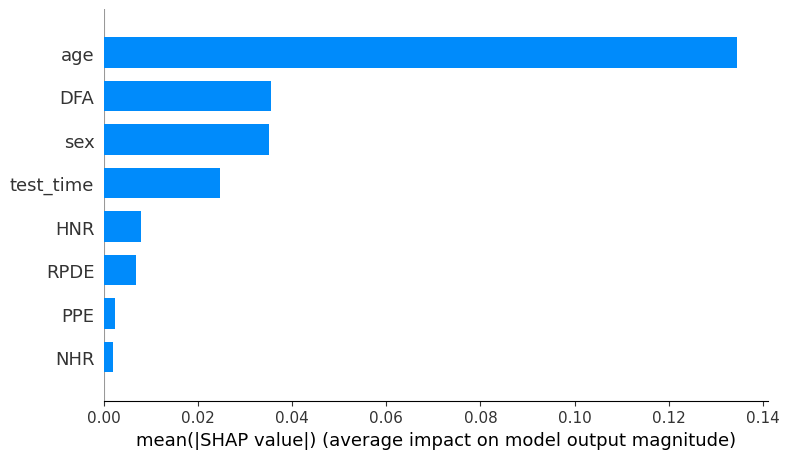


📊  Feature importance for UCI total UPDRS prediction — VIF-BOBE-RRF model (Beeswarm)


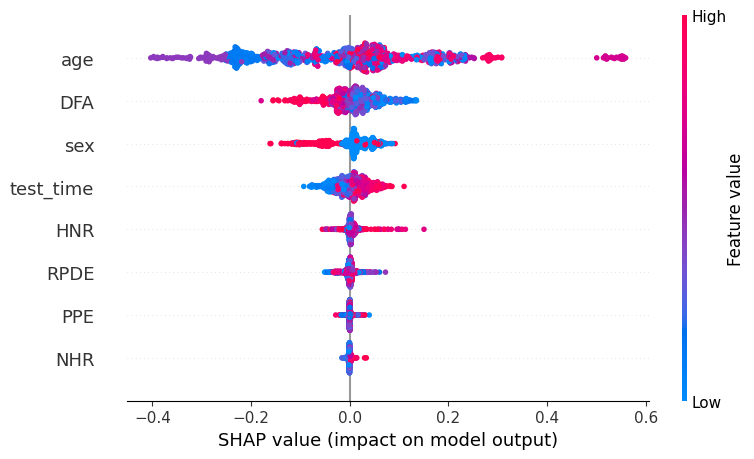

In [2]:
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# --- Load Data ---
data = pd.read_excel("VIFdata.xlsx")
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Selected features from RReliefF + VIF
selected_features = ['age', 'sex', 'test_time', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']
X_selected = X[selected_features]

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

# --- Define Model 1 (VIF-BOBE-RRF) ---
model1 = Pipeline([
    ('scaler', StandardScaler()),
    ('bagging', BaggingRegressor(
        estimator=DecisionTreeRegressor(min_samples_leaf=2),
        n_estimators=477,
        max_features=len(selected_features),
        random_state=42,
        n_jobs=-1
    ))
])

# --- Fit Model ---
model1.fit(X_train, y_train)

# --- Scale Test Data ---
scaler1 = model1.named_steps['scaler']
X_test_scaled1 = scaler1.transform(X_test)

# Convert scaled test data back to DataFrame for SHAP
X_test_df1 = pd.DataFrame(X_test_scaled1, columns=selected_features)

# --- SHAP for Model 1 ---
print("\n🔍 SHAP for Model 1 (VIF-BOBE-RRF)")
shap_values_list1 = [
    shap.TreeExplainer(tree).shap_values(X_test_scaled1)
    for tree in model1.named_steps['bagging'].estimators_
]
shap_values1_avg = np.mean(shap_values_list1, axis=0)

# --- SHAP Summary Plots (Bar) ---
print("\n📊 Global Feature Importance for UCI total UPDRS prediction — VIF-BOBE-RRF model (Bar Plot)")
shap.summary_plot(shap_values1_avg, X_test_df1, plot_type="bar", show=False)
plt.gca().grid(False)  # Remove grid lines
plt.show()

# --- SHAP Summary Plots (Beeswarm) ---
print("\n📊  Feature importance for UCI total UPDRS prediction — VIF-BOBE-RRF model (Beeswarm)")
shap.summary_plot(shap_values1_avg, X_test_df1, show=False)
plt.gca().grid(False)
plt.show()



Explaining instance index: 10


C:\Users\Rosha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Intercept 0.5274931475203494
Prediction_local [0.5635263]
Right: 0.570539643331735


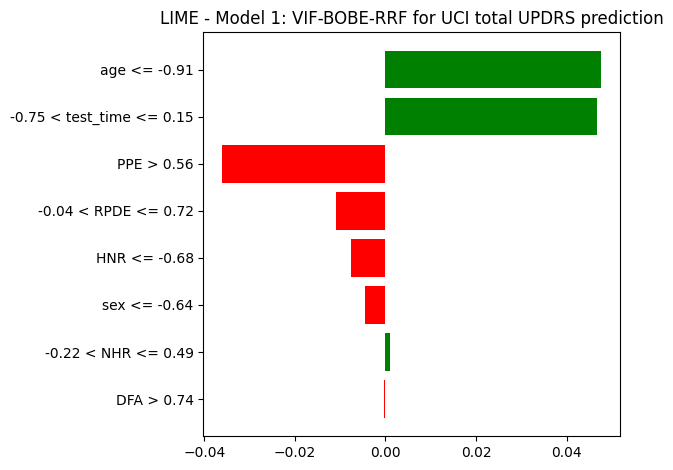

C:\Users\Rosha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Intercept 0.5280052376184509
Prediction_local [0.56376573]
Right: 0.5699391580021308


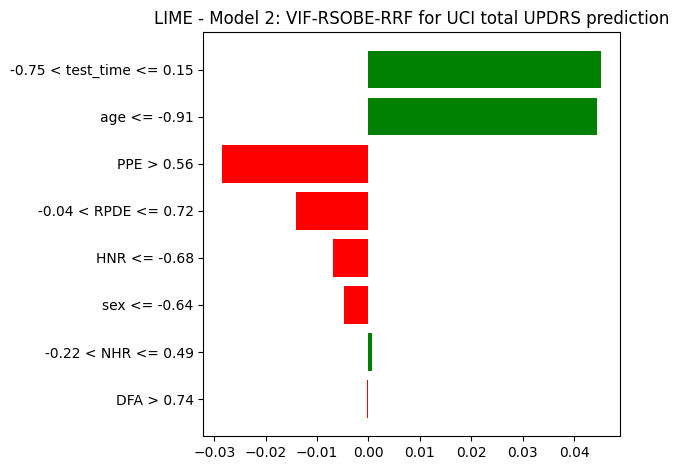

In [7]:
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# --- Load Data ---
data = pd.read_excel("VIFdata.xlsx")
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Selected features from RReliefF + VIF
selected_features = ['age', 'sex', 'test_time', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']
X_selected = X[selected_features]

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

# --- Define Models ---
model1 = Pipeline([
    ('scaler', StandardScaler()),
    ('bagging', BaggingRegressor(
        estimator=DecisionTreeRegressor(min_samples_leaf=2),
        n_estimators=477,
        max_features=len(selected_features),
        random_state=42,
        n_jobs=-1
    ))
])

model2 = Pipeline([
    ('scaler', StandardScaler()),
    ('bagging', BaggingRegressor(
        estimator=DecisionTreeRegressor(min_samples_leaf=2),
        n_estimators=121,
        max_features=len(selected_features),
        random_state=42,
        n_jobs=-1
    ))
])

# --- Fit Models ---
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

# --- Scale Test Data ---
scaler1 = model1.named_steps['scaler']
scaler2 = model2.named_steps['scaler']
X_test_scaled1 = scaler1.transform(X_test)
X_test_scaled2 = scaler2.transform(X_test)

# --- Setup LIME Explainers ---
explainer1 = LimeTabularExplainer(
    training_data=X_test_scaled1,
    feature_names=X_test.columns.tolist(),
    mode='regression',
    verbose=True
)

explainer2 = LimeTabularExplainer(
    training_data=X_test_scaled2,
    feature_names=X_test.columns.tolist(),
    mode='regression',
    verbose=True
)

# --- Pick a sample instance ---
sample_idx = 10  # You can change this to test other patients
print(f"\nExplaining instance index: {sample_idx}")

# --- LIME Explanation for Model 1 ---
exp1 = explainer1.explain_instance(
    X_test_scaled1[sample_idx],
    model1.predict,
    num_features=8
)
fig1 = exp1.as_pyplot_figure()
plt.title("LIME - Model 1: VIF-BOBE-RRF for UCI total UPDRS prediction")
plt.tight_layout()
plt.show()

# --- LIME Explanation for Model 2 ---
exp2 = explainer2.explain_instance(
    X_test_scaled2[sample_idx],
    model2.predict,
    num_features=8
)
fig2 = exp2.as_pyplot_figure()
plt.title("LIME - Model 2: VIF-RSOBE-RRF for UCI total UPDRS prediction")
plt.tight_layout()
plt.show()



🔍 SHAP for Model 1 (VIF-BOBE-RRF)

📊 Global Feature Importance for UCI motor UPDRS prediction — VIF-BOBE-RRF model (Bar Plot)


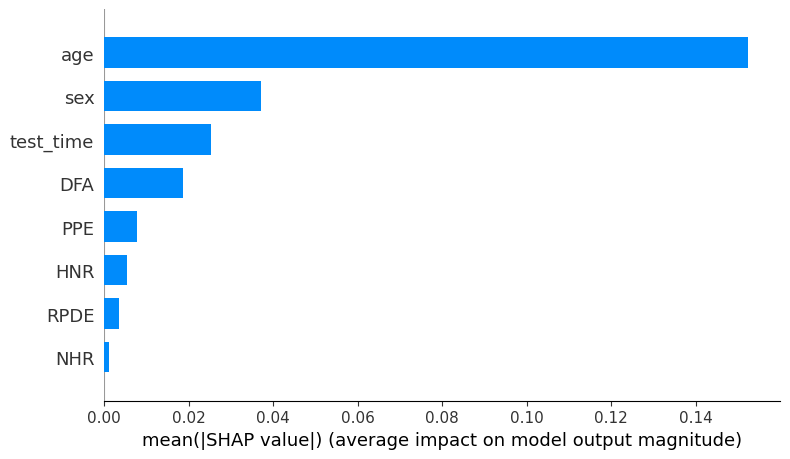


📊 Feature importance for UCI motor UPDRS prediction — VIF-BOBE-RRF model (Beeswarm)


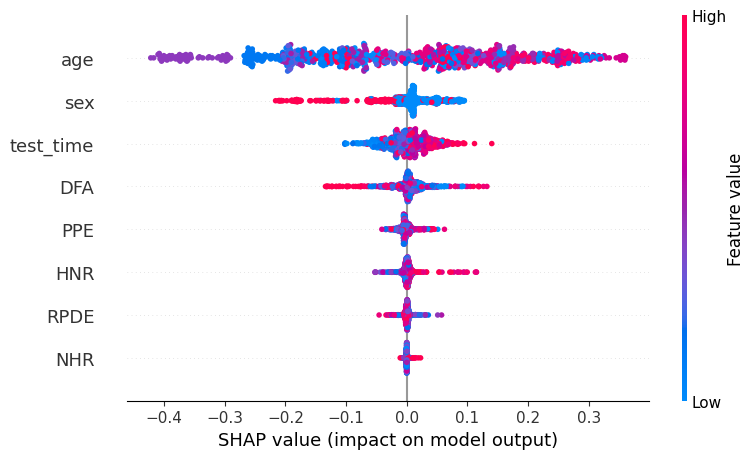

In [4]:
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# --- Load Data ---
data = pd.read_excel("VIFdata1.xlsx")
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Selected features from RReliefF + VIF
selected_features = ['age', 'sex', 'test_time', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']
X_selected = X[selected_features]

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

# --- Define Model 1 (VIF-BOBE-RRF) ---
model1 = Pipeline([
    ('scaler', StandardScaler()),
    ('bagging', BaggingRegressor(
        estimator=DecisionTreeRegressor(min_samples_leaf=2),
        n_estimators=477,
        max_features=len(selected_features),
        random_state=42,
        n_jobs=-1
    ))
])

# --- Fit Model ---
model1.fit(X_train, y_train)

# --- Scale Test Data ---
scaler1 = model1.named_steps['scaler']
X_test_scaled1 = scaler1.transform(X_test)

# --- SHAP for Model 1 ---
print("\n🔍 SHAP for Model 1 (VIF-BOBE-RRF)")
shap_values_list1 = [
    shap.TreeExplainer(tree).shap_values(X_test_scaled1)
    for tree in model1.named_steps['bagging'].estimators_
]
shap_values1_avg = np.mean(shap_values_list1, axis=0)

# --- SHAP Summary Plots (Bar) ---
print("\n📊 Global Feature Importance for UCI motor UPDRS prediction — VIF-BOBE-RRF model (Bar Plot)")
shap.summary_plot(shap_values1_avg, X_test, feature_names=X_test.columns, plot_type="bar")

# --- SHAP Summary Plots (Beeswarm) ---
print("\n📊 Feature importance for UCI motor UPDRS prediction — VIF-BOBE-RRF model (Beeswarm)")
shap.summary_plot(shap_values1_avg, X_test, feature_names=X_test.columns)



Explaining instance index: 10


C:\Users\Rosha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Intercept 0.49066119133695724
Prediction_local [0.68216017]
Right: 0.7523000343644447


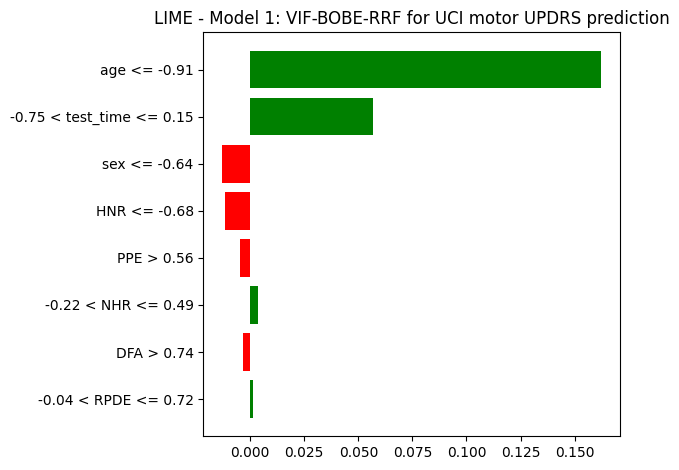

C:\Users\Rosha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Intercept 0.480781051601096
Prediction_local [0.70003214]
Right: 0.7567842998193474


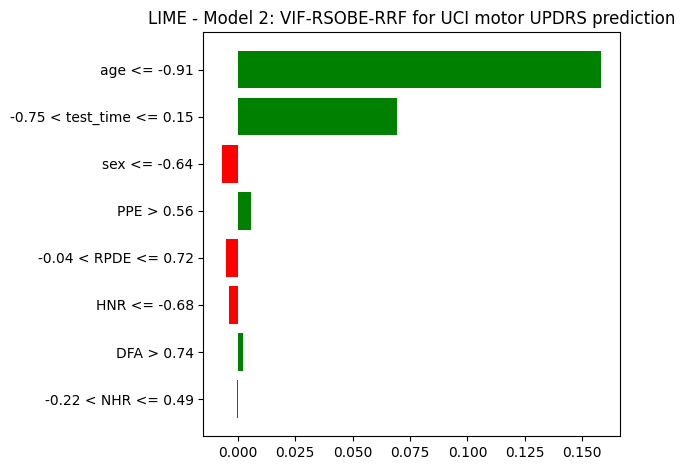

In [16]:
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# --- Load Data ---
data = pd.read_excel("VIFdata1.xlsx")
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Selected features from RReliefF + VIF
selected_features = ['age', 'sex', 'test_time', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']
X_selected = X[selected_features]

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

# --- Define Models ---
model1 = Pipeline([
    ('scaler', StandardScaler()),
    ('bagging', BaggingRegressor(
        estimator=DecisionTreeRegressor(min_samples_leaf=2),
        n_estimators=477,
        max_features=len(selected_features),
        random_state=42,
        n_jobs=-1
    ))
])

model2 = Pipeline([
    ('scaler', StandardScaler()),
    ('bagging', BaggingRegressor(
        estimator=DecisionTreeRegressor(min_samples_leaf=2),
        n_estimators=121,
        max_features=len(selected_features),
        random_state=42,
        n_jobs=-1
    ))
])

# --- Fit Models ---
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

# --- Scale Test Data ---
scaler1 = model1.named_steps['scaler']
scaler2 = model2.named_steps['scaler']
X_test_scaled1 = scaler1.transform(X_test)
X_test_scaled2 = scaler2.transform(X_test)

# --- Setup LIME Explainers ---
explainer1 = LimeTabularExplainer(
    training_data=X_test_scaled1,
    feature_names=X_test.columns.tolist(),
    mode='regression',
    verbose=True
)

explainer2 = LimeTabularExplainer(
    training_data=X_test_scaled2,
    feature_names=X_test.columns.tolist(),
    mode='regression',
    verbose=True
)

# --- Pick a sample instance ---
sample_idx = 10  # You can change this to test other patients
print(f"\nExplaining instance index: {sample_idx}")

# --- LIME Explanation for Model 1 ---
exp1 = explainer1.explain_instance(
    X_test_scaled1[sample_idx],
    model1.predict,
    num_features=8
)
fig1 = exp1.as_pyplot_figure()
plt.title("LIME - Model 1: VIF-BOBE-RRF for UCI motor UPDRS prediction")
plt.tight_layout()
plt.show()

# --- LIME Explanation for Model 2 ---
exp2 = explainer2.explain_instance(
    X_test_scaled2[sample_idx],
    model2.predict,
    num_features=8
)
fig2 = exp2.as_pyplot_figure()
plt.title("LIME - Model 2: VIF-RSOBE-RRF for UCI motor UPDRS prediction")
plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample
import numpy as np

def evaluate_model_advanced(model, X_train, y_train, X_test, y_test, model_name, n_bootstrap=1000):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics for training set
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Metrics for testing set
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Cohen's f squared (effect size) on test set
    f_squared = test_r2 / (1 - test_r2) if test_r2 < 1 else np.inf

    # CV_MAE on test set
    y_test_mean = np.mean(y_test)
    cv_mae = test_mae / y_test_mean if y_test_mean != 0 else np.nan

    # Bootstrap confidence intervals for MAE and RMSE on test set
    mae_samples = []
    rmse_samples = []
    for _ in range(n_bootstrap):
        indices = resample(range(len(y_test)), replace=True)
        y_true_bs = y_test.iloc[indices] if hasattr(y_test, "iloc") else y_test[indices]
        y_pred_bs = y_test_pred[indices]
        mae_bs = mean_absolute_error(y_true_bs, y_pred_bs)
        rmse_bs = np.sqrt(mean_squared_error(y_true_bs, y_pred_bs))
        mae_samples.append(mae_bs)
        rmse_samples.append(rmse_bs)

    ci_lower_mae = np.percentile(mae_samples, 2.5)
    ci_upper_mae = np.percentile(mae_samples, 97.5)
    ci_lower_rmse = np.percentile(rmse_samples, 2.5)
    ci_upper_rmse = np.percentile(rmse_samples, 97.5)

    # Averages
    avg_rmse = (train_rmse + test_rmse) / 2
    avg_mae = (train_mae + test_mae) / 2
    avg_r2 = (train_r2 + test_r2) / 2

    # Output
    print(f"\n📊 {model_name} Performance:")
    print(f"Training RMSE: {train_rmse:.6f}")
    print(f"Training MAE:  {train_mae:.6f}")
    print(f"Training R²:   {train_r2:.6f}")
    print(f"Testing RMSE:  {test_rmse:.6f}")
    print(f"Testing MAE:   {test_mae:.6f}")
    print(f"Testing R²:    {test_r2:.6f}")
    print(f"Average RMSE:  {avg_rmse:.6f}")
    print(f"Average MAE:   {avg_mae:.6f}")
    print(f"Average R²:    {avg_r2:.6f}")
    print(f"Cohen's f² (effect size): {f_squared:.6f}")
    print(f"CV_MAE: {cv_mae:.6f}")
    print(f"95% CI MAE: [{ci_lower_mae:.6f}, {ci_upper_mae:.6f}]")
    print(f"95% CI RMSE: [{ci_lower_rmse:.6f}, {ci_upper_rmse:.6f}]")

# Usage example:
evaluate_model_advanced(model1, X_train, y_train, X_test, y_test, "Model 1: VIF-BOBE-RRF")
evaluate_model_advanced(model2, X_train, y_train, X_test, y_test, "Model 2: VIF-RSOBE-RRF")



📊 Model 1: VIF-BOBE-RRF Performance:
Training RMSE: 0.020213
Training MAE:  0.008288
Training R²:   0.992821
Testing RMSE:  0.050769
Testing MAE:   0.018643
Testing R²:    0.952716
Average RMSE:  0.035491
Average MAE:   0.013465
Average R²:    0.972768
Cohen's f² (effect size): 20.149000
CV_MAE: 0.039075
95% CI MAE: [0.015734, 0.021623]
95% CI RMSE: [0.039964, 0.060812]

📊 Model 2: VIF-RSOBE-RRF Performance:
Training RMSE: 0.020706
Training MAE:  0.008593
Training R²:   0.992466
Testing RMSE:  0.051162
Testing MAE:   0.018914
Testing R²:    0.951981
Average RMSE:  0.035934
Average MAE:   0.013753
Average R²:    0.972223
Cohen's f² (effect size): 19.824918
CV_MAE: 0.039644
95% CI MAE: [0.016147, 0.021860]
95% CI RMSE: [0.041474, 0.060443]


In [18]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np

# Custom MAE scorer (greater_is_better=False for error metrics)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Compute negative MAEs (so take absolute to interpret)
mae_scores_model1 = -cross_val_score(model1, X_train, y_train, scoring=mae_scorer, cv=cv)
mae_scores_model2 = -cross_val_score(model2, X_train, y_train, scoring=mae_scorer, cv=cv)

print("Model 1 - MAE scores from 10-fold CV:", mae_scores_model1)
print("Model 2 - MAE scores from 10-fold CV:", mae_scores_model2)


Model 1 - MAE scores from 10-fold CV: [0.0234797  0.01506841 0.01798862 0.02052016 0.02036716 0.0211498
 0.01653573 0.01924943 0.01949319 0.02067987]
Model 2 - MAE scores from 10-fold CV: [0.02430025 0.0153943  0.01733276 0.02073973 0.02086874 0.02142171
 0.01718472 0.01955442 0.01959727 0.02044779]


In [19]:
from scipy.stats import ttest_rel, wilcoxon

# Paired t-test
t_stat, p_ttest = ttest_rel(mae_scores_model1, mae_scores_model2)

# Wilcoxon signed-rank test
w_stat, p_wilcoxon = wilcoxon(mae_scores_model1, mae_scores_model2)

print(f"Paired t-test p-value: {p_ttest:.6f}")
print(f"Wilcoxon signed-rank test p-value: {p_wilcoxon:.6f}")


Paired t-test p-value: 0.120144
Wilcoxon signed-rank test p-value: 0.130859


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 3955, number of used features: 8
[LightGBM] [Info] Start training from score 0.472043
            Model        R2      RMSE  RMSE_CI_Lower  RMSE_CI_Upper       MAE  \
10   RandomForest  0.953453  0.050372       0.039598       0.060887  0.018320   
11        XGBoost  0.944531  0.054988       0.046842       0.063256  0.031319   
12       LightGBM  0.940872  0.056772       0.047382       0.065900  0.031104   
13       CatBoost  0.876286  0.082121       0.077093       0.087535  0.061257   
9          RSODTR  0.848457  0.090889       0.082427       0.098891  0.054057   
8           DTree  0.848457  0.090889       0.082099       0.098530  0.054057   
6         LSBoost  0.605304  0.146681       0.141097       0.152395  0.123017   
7   Bayes_LS

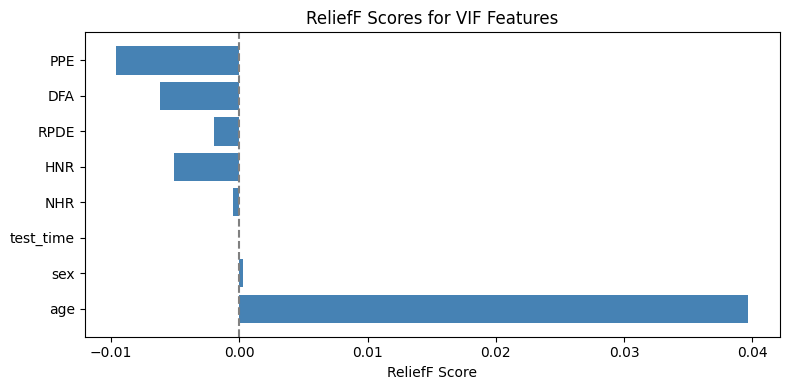

In [20]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ttest_rel, t
import matplotlib.pyplot as plt

# External libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.utils import resample

# ------------------------
# Bootstrap CI helper
# ------------------------
def bootstrap_ci(y_true, y_pred, metric_func, n_bootstrap=1000, ci=95):
    scores = []
    n = len(y_true)
    for _ in range(n_bootstrap):
        indices = resample(range(n), replace=True)
        y_true_bs = y_true.iloc[indices] if hasattr(y_true, "iloc") else y_true[indices]
        y_pred_bs = y_pred[indices]
        score = metric_func(y_true_bs, y_pred_bs)
        scores.append(score)
    lower = np.percentile(scores, (100 - ci) / 2)
    upper = np.percentile(scores, 100 - (100 - ci) / 2)
    return lower, upper

# ------------------------
# 1. Load the VIF-reduced data
# ------------------------
data = pd.read_excel("VIFdata1.xlsx")  # 8 features + 1 target column

# ------------------------
# 2. ReliefF scores for specific models only
# ------------------------
feature_names = ['age', 'sex', 'test_time', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']
rrf_scores = [0.0397, 0.0003, 0, -0.0005, -0.0051, -0.0020, -0.0062, -0.0096]

rrf_df = pd.DataFrame({'feature': feature_names, 'score': rrf_scores})
selected_features_rrf = rrf_df['feature'].tolist()

# Use VIF features for most models
X_vif = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Use RReliefF features only for specific models
X_rrf = data[selected_features_rrf]

# ------------------------
# 3. Train/Test Split (80/20)
# ------------------------
X_vif_train, X_vif_test, y_train, y_test = train_test_split(
    X_vif, y, test_size=0.2, random_state=42
)

X_rrf_train, X_rrf_test, _, _ = train_test_split(
    X_rrf, y, test_size=0.2, random_state=42
)

# 10-Fold CV setup (if needed later)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# ------------------------
# 4. Define Models
# ------------------------
models = {
    'MLR': Pipeline([
        ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
        ('regressor', LinearRegression())
    ]),
    'GPR': Pipeline([
        ('scaler', StandardScaler()),
        ('gpr', GaussianProcessRegressor(kernel=RBF()))
    ]),
    'SVR_PCA': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('svr', SVR(kernel='rbf'))
    ]),
    'MLP_PCA': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('mlp', MLPRegressor(hidden_layer_sizes=(100,), activation='relu', max_iter=1000))
    ]),
    'BOMLP': Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000))
    ]),
    'RSOMLP': Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000))
    ]),
    'LSBoost': GradientBoostingRegressor(n_estimators=30, learning_rate=0.1, min_samples_leaf=8),
    'Bayes_LSBoost': GradientBoostingRegressor(n_estimators=30, learning_rate=0.1, min_samples_leaf=8),
    'DTree': DecisionTreeRegressor(min_samples_leaf=36),
    'RSODTR': DecisionTreeRegressor(min_samples_leaf=36),

    # New models added:
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'CatBoost': CatBoostRegressor(iterations=100, learning_rate=0.1, random_state=42, verbose=0)
}

# ------------------------
# 5. Compute stats with bootstrap CIs for each model
# ------------------------
def compute_stats(y_true, y_pred, n_bootstrap=1000):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    f_squared = r2 / (1 - r2) if r2 < 1 else np.inf
    cv_mae = mae / np.mean(y_true) if np.mean(y_true) != 0 else np.nan

    # Bootstrap confidence intervals
    rmse_ci_lower, rmse_ci_upper = bootstrap_ci(y_true, y_pred, lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)), n_bootstrap)
    mae_ci_lower, mae_ci_upper = bootstrap_ci(y_true, y_pred, mean_absolute_error, n_bootstrap)

    # Paired t-test p-value between y_true and y_pred residuals
    residuals_true = y_true - y_true.mean()
    residuals_pred = y_pred - y_pred.mean()
    _, p_value = ttest_rel(residuals_true, residuals_pred)

    return {
        'R2': r2,
        'RMSE': rmse,
        'RMSE_CI_Lower': rmse_ci_lower,
        'RMSE_CI_Upper': rmse_ci_upper,
        'MAE': mae,
        'MAE_CI_Lower': mae_ci_lower,
        'MAE_CI_Upper': mae_ci_upper,
        "Cohen_f2": f_squared,
        "CV_MAE": cv_mae,
        "P_Value": p_value
    }

# ------------------------
# 6. Evaluate all models and store results
# ------------------------
results = []
rrf_models = ['Bayes_LSBoost', 'RSODTR']  # Models using RReliefF features

for name, model in models.items():
    if name in rrf_models:
        model.fit(X_rrf_train, y_train)
        y_pred = model.predict(X_rrf_test)
    else:
        model.fit(X_vif_train, y_train)
        y_pred = model.predict(X_vif_test)

    stats = compute_stats(y_test, y_pred)
    stats['Model'] = name
    results.append(stats)

# ------------------------
# 7. Display Results as DataFrame sorted by R2
# ------------------------
results_df = pd.DataFrame(results)
results_df = results_df[['Model', 'R2', 'RMSE', 'RMSE_CI_Lower', 'RMSE_CI_Upper', 
                         'MAE', 'MAE_CI_Lower', 'MAE_CI_Upper', "Cohen_f2", "CV_MAE", "P_Value"]]
print(results_df.sort_values(by='R2', ascending=False))

# ------------------------
# 8. Plot ReliefF Feature Importances
# ------------------------
plt.figure(figsize=(8, 4))
plt.barh(rrf_df['feature'], rrf_df['score'], color='steelblue')
plt.axvline(0, color='gray', linestyle='--')
plt.title("ReliefF Scores for VIF Features")
plt.xlabel("ReliefF Score")
plt.tight_layout()
plt.show()
